In [ ]:
# ----------------------------------------------------------------------------
# Library
# ----------------------------------------------------------------------------

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

Figure saved to C:\Users\manue\Desktop\perm_importance.png


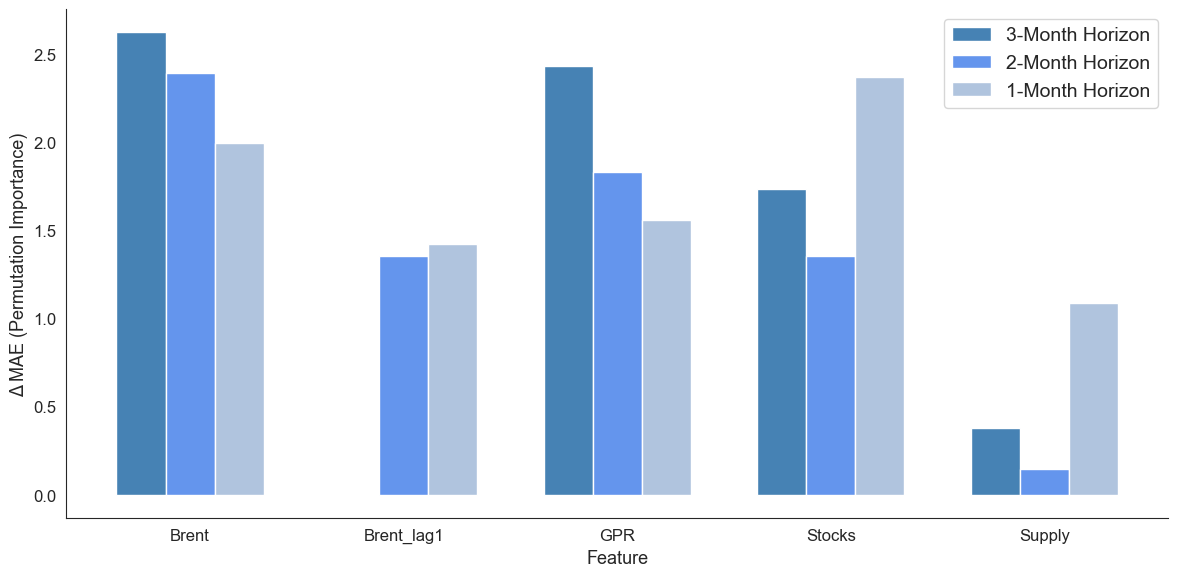

In [1]:
# ----------------------------------------------------------------------------
# Comparison Plots
# ----------------------------------------------------------------------------

# ----------------------------------------------------------------------------
# PATHS TO PERMUTATION-IMPORTANCE CSV FILES
# ----------------------------------------------------------------------------

file_paths = {
    1: r"C:\Users\manue\Desktop\1 LSTM\brent_perm_importance.csv",
    2: r"C:\Users\manue\Desktop\2 LSTM\brent_perm_importance.csv",
    3: r"C:\Users\manue\Desktop\3 LSTM\brent_perm_importance.csv",
}

# ----------------------------------------------------------------------------

figsize       = (12, 6)
bar_width     = 0.23
save_png_path = r"C:\Users\manue\Desktop\perm_importance.png"
show_plot     = True

# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
    "savefig.facecolor": "white",
    "axes.grid":    False,
})
sns.set_style("white")

# Read Data
frames = []
for h, path in file_paths.items():
    p = Path(path)
    if not p.is_file():
        raise FileNotFoundError(f"Missing CSV for {h}-month horizon: {p}")
    frames.append(
        pd.read_csv(p)
          .assign(Horizon=h)
          .rename(columns={"Delta_MAE": "Delta_MAE"})
    )
df_all = pd.concat(frames, ignore_index=True)

# Prepare Structure
features = df_all["Feature"].unique()
features.sort()
x_pos = np.arange(len(features))                # centre of each feature group

# Colours
horizons = [3, 2, 1]                            # plotting order
colour_map = {3: "steelblue", 2: "cornflowerblue", 1: "lightsteelblue"}

# Plot
fig, ax = plt.subplots(figsize=figsize)

for i, h in enumerate(horizons):
    subset = df_all[df_all["Horizon"] == h]
    # Align bar
    offset = (i - 1) * bar_width
    ax.bar(
        x_pos + offset,
        subset.set_index("Feature").loc[features, "Delta_MAE"],
        width=bar_width,
        color=colour_map[h],
        label=f"{h}-Month Horizon",
    )

# Axis
ax.set_xlabel("Feature", fontsize=13)
ax.set_ylabel("Δ MAE (Permutation Importance)", fontsize=13)

ax.set_xticks(x_pos)
ax.set_xticklabels(features, rotation=0, ha="center", fontsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.legend(loc="upper right", frameon=True)      # legend top-right

sns.despine(ax=ax)
plt.tight_layout()

# Save
if save_png_path:
    plt.savefig(save_png_path, dpi=300, bbox_inches="tight")
    print(f"Figure saved to {save_png_path}")

if show_plot:
    plt.show()

plt.close()


Pie charts saved to: C:\Users\manue\Desktop\perm_importance_pies_pct.png


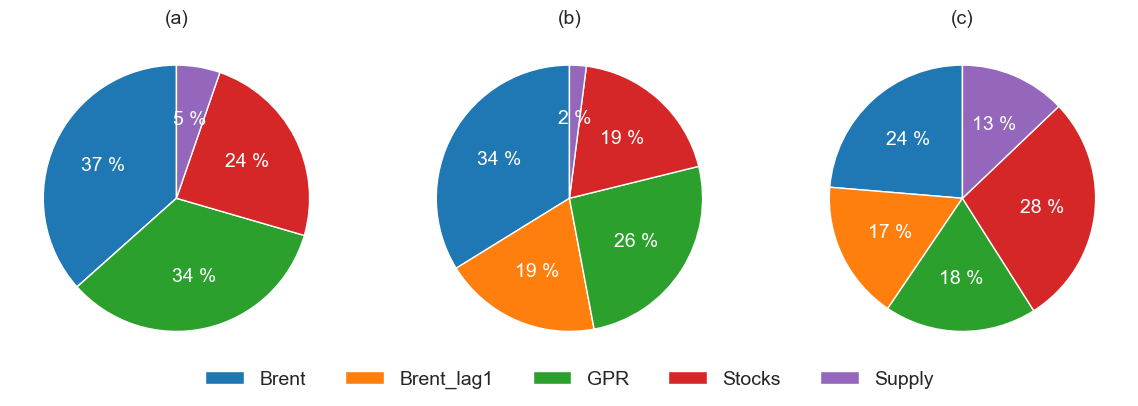

In [9]:
# ----------------------------------------------------------------------------
# Pie charts of permutation importance with % labels
# ----------------------------------------------------------------------------


# feature order and colours
features = ["Brent", "Brent_lag1", "GPR", "Stocks", "Supply"]
feature_cols = [
    "#1f77b4",   # Brent
    "#ff7f0e",   # Brent_lag1
    "#2ca02c",   # GPR
    "#d62728",   # Stocks
    "#9467bd",   # Supply
]
colour_map = dict(zip(features, feature_cols))

horizons = [3, 2, 1]                       # plotting order
titles   = ["(a)", "(b)", "(c)"]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
pct_fmt = lambda pct: f"{pct:.0f} %" if pct > 0 else ""

for ax, h, title in zip(axes, horizons, titles):
    sub     = df_all[df_all["Horizon"] == h].set_index("Feature").loc[features]
    sizes   = sub["Delta_MAE"].clip(lower=0).values
    colours = [colour_map[f] for f in features]

    wedges, texts, autotexts = ax.pie(
        sizes,
        colors=colours,
        startangle=90,
        autopct=pct_fmt,
        textprops=dict(color="white", fontsize=10),   # slice labels
        wedgeprops=dict(edgecolor="white"),
    )


    for t in autotexts:
        t.set_fontsize(14)
        t.set_color("white")

    ax.set_title(title, fontsize=14)

fig.legend(wedges, features, ncol=5, loc="lower center", frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])

out_png = Path(r"C:\Users\manue\Desktop\perm_importance_pies_pct.png")
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Pie charts saved to: {out_png}")
plt.show()


Combined plot saved to: C:\Users\manue\Desktop\lstm_vs_arima_all.png


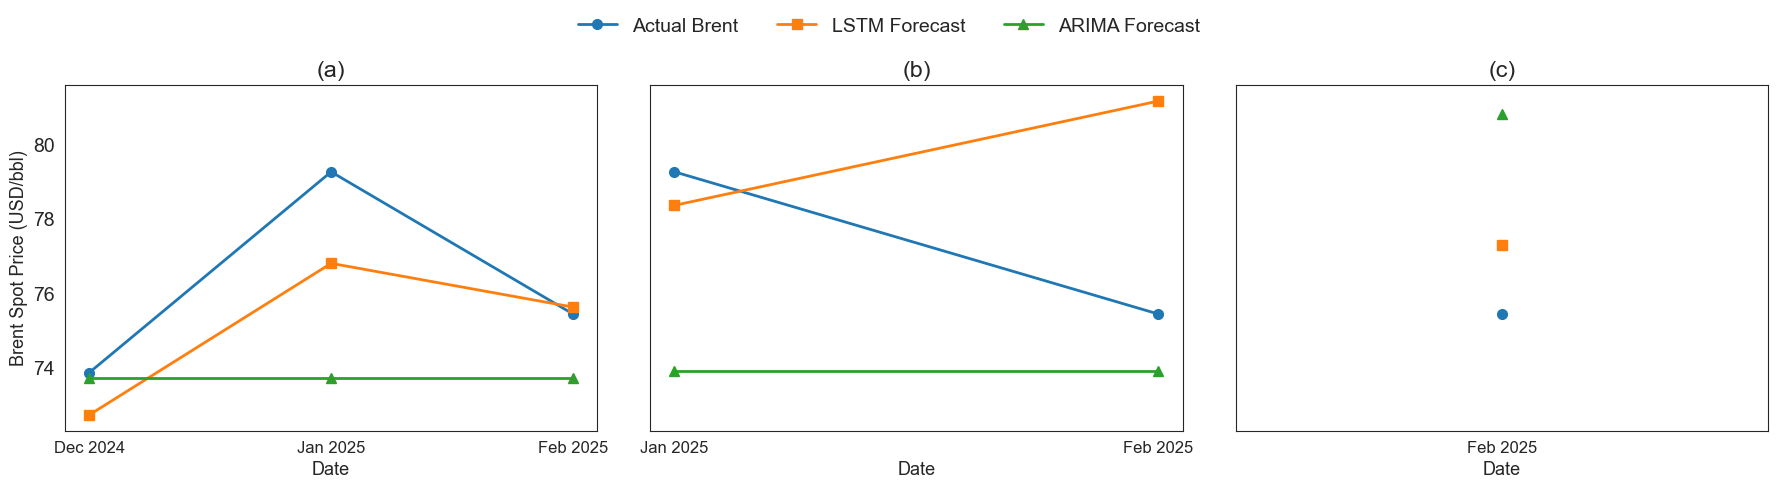

In [1]:
# ----------------------------------------------------------------------------
# Comparison Plot Actual Brent vs LSTM vs ARIMA
# ----------------------------------------------------------------------------
from pathlib import Path
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Load
base = Path(r"C:\Users\manue\Desktop")

lstm_paths  = {h: base / f"{h} LSTM"  / "brent_forecast_vs_actual.csv"
               for h in (1, 2, 3)}
arima_paths = {h: base / f"{h} ARIMA" / "arima_forecast_vs_actual.xlsx"
               for h in (1, 2, 3)}

# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
    "axes.grid":    False,
})
sns.set_style("white")

figsize       = (18, 5)   # width, height in inches
line_width    = 2.0
marker_size   = 7
show_plot     = True

# Helper
def read_lstm(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path).rename(columns=str.strip)
    df["Date"] = pd.to_datetime(df["Month"])
    return df[["Date", "Actual_Brent", "LSTM_Forecast"]]

def read_arima(path: Path) -> pd.DataFrame:
    df = pd.read_excel(path).rename(columns=str.strip)
    df["Date"] = pd.to_datetime(df.iloc[:, 0])
    arima_col = [c for c in df.columns if "ARIMA_Forecast" in c][0]
    return df[["Date", arima_col]].rename(columns={arima_col: "ARIMA_Forecast"})

# Read and merge
merged_by_horizon = {}
for h in (3, 2, 1):                              # keep display order
    df = (
        pd.merge(
            read_lstm(lstm_paths[h]),
            read_arima(arima_paths[h]),
            on="Date",
            how="inner",
        )
        .sort_values("Date")
    )
    merged_by_horizon[h] = df

# Plot
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
panel_labels = ["(a)", "(b)", "(c)"]
month_fmt = mdates.DateFormatter("%b %Y")         # eg "Dec 2024"

for ax, label, (horizon, df) in zip(axes, panel_labels, merged_by_horizon.items()):
    ax.plot(df["Date"], df["Actual_Brent"],
            marker="o", lw=line_width, markersize=marker_size, label="Actual Brent")
    ax.plot(df["Date"], df["LSTM_Forecast"],
            marker="s", lw=line_width, markersize=marker_size, label="LSTM Forecast")
    ax.plot(df["Date"], df["ARIMA_Forecast"],
            marker="^", lw=line_width, markersize=marker_size, label="ARIMA Forecast")

    ax.set_title(label)                           # panel label only

    # x-tick placement
    if horizon in (3, 1):                         # show only the three dates
        ax.set_xticks(df["Date"])
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(month_fmt)
    ax.tick_params(axis="x", rotation=0, labelsize=12)

    ax.set_xlabel("Date", fontsize=13)
    if ax is axes[0]:
        ax.set_ylabel("Brent Spot Price (USD/bbl)", fontsize=13)

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3,
           frameon=False, fontsize="medium")

plt.tight_layout(rect=[0, 0, 1, 0.92])

# Save
out_png = base / "lstm_vs_arima_all.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Combined plot saved to: {out_png}")

if show_plot:
    plt.show()
plt.close()


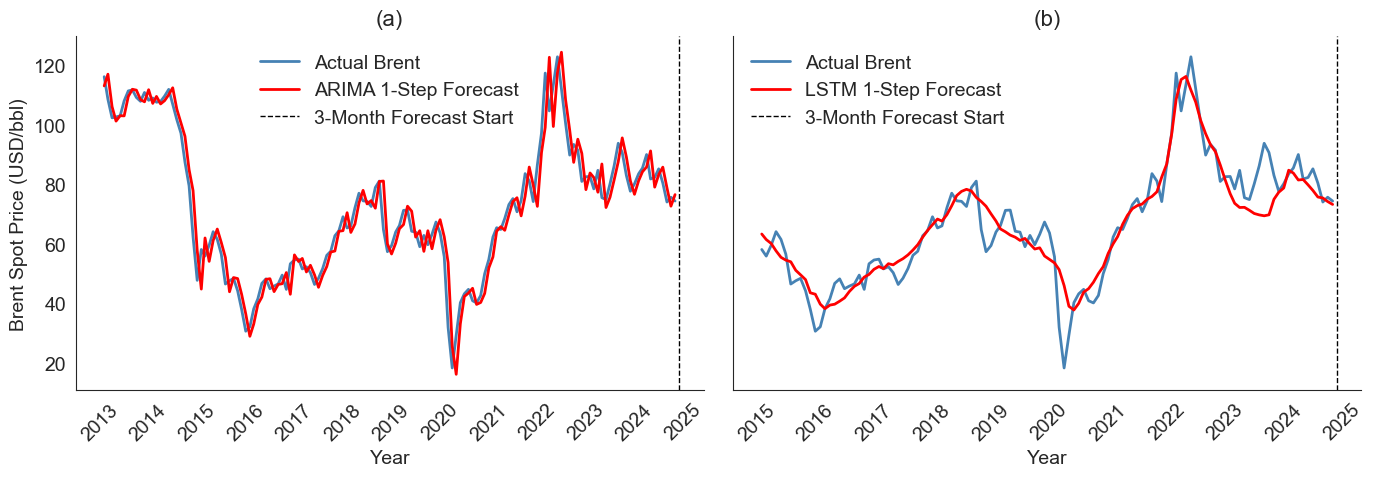

In [10]:
# ----------------------------------------------------------------------------
# Walk-Forward 1-Step Forecasts – ARIMA vs LSTM
# ----------------------------------------------------------------------------

# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
    "savefig.facecolor": "white",
})
sns.set_style("white")

# Load
arima_path = r"C:\Users\manue\Desktop\arima_1step_forecast_vs_actual.xlsx"
lstm_path  = r"C:\Users\manue\Desktop\lstm_1step_forecast_vs_actual.xlsx"

df_arima = pd.read_excel(arima_path, parse_dates=["Date"])
df_lstm  = pd.read_excel(lstm_path,  parse_dates=["Date"])

# First month of 3-month hold-out period
forecast_start = df_arima["Date"].max() + pd.DateOffset(months=1)

# Plot
fig, (ax_a, ax_b) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# (a) ARIMA panel
ax_a.plot(df_arima["Date"], df_arima["Actual_Brent"],
          color="steelblue", lw=2, label="Actual Brent")
ax_a.plot(df_arima["Date"], df_arima["ARIMA_1Step_Forecast"],
          color="red", lw=2, label="ARIMA 1-Step Forecast")
ax_a.axvline(forecast_start, color="black", linestyle="--", linewidth=1,
             label="3-Month Forecast Start")

ax_a.set_title("(a)", fontsize=16, pad=8)
ax_a.set_xlabel("Year");  ax_a.set_ylabel("Brent Spot Price (USD/bbl)")
ax_a.xaxis.set_major_locator(mdates.YearLocator())
ax_a.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax_a.tick_params(axis="x", rotation=45)
ax_a.legend(frameon=False)

# (b) LSTM panel
ax_b.plot(df_lstm["Date"], df_lstm["Actual_Brent"],
          color="steelblue", lw=2, label="Actual Brent")
ax_b.plot(df_lstm["Date"], df_lstm["LSTM_1Step_Forecast"],
          color="red", lw=2, label="LSTM 1-Step Forecast")
ax_b.axvline(forecast_start, color="black", linestyle="--", linewidth=1,
             label="3-Month Forecast Start")          # ← add label here

ax_b.set_title("(b)", fontsize=16, pad=8)
ax_b.set_xlabel("Year")
ax_b.xaxis.set_major_locator(mdates.YearLocator())
ax_b.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax_b.tick_params(axis="x", rotation=45)
ax_b.legend(frameon=False)

sns.despine(ax=ax_a);  sns.despine(ax=ax_b)
plt.tight_layout()

# Save
fig.savefig(r"C:\Users\manue\Desktop\arima_vs_lstm_1step.png", dpi=300)
plt.show()
